## Prepare input data

This notebook helps you load the experimental data from an excel file or a csv file, and plot it

Then you can use the next part to generate a config file for the bayesian inference 

In [1]:
# load the relevant modules for the analysis

from pathlib import Path
import os

import numpy as np
import pandas as pd
from scipy import interpolate

from pl_temp_fit import Exp_data_utils, config_utils

# access the right directory
# os.chdir('/home/mohammed/Work/pl_temp_fit/')

os.chdir("/media/mohammed/Work/Work/pl_temp_fit/")

In [2]:
exp_dataset_path =Path("/media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/")


In [3]:
# Process the input data
# if the data are in xlsx format convert them to csv


def from_xslx_to_csv(xlsx_file):
    data = pd.read_excel(xlsx_file)
    hws = np.arange(0.95, 1.8, 0.01)
    y = np.zeros((hws.size, len(data.values[0, :])))
    y[:, 0] = hws
    for i in range(1, len(data.values[0, :])):
        f = interpolate.interp1d(
            data.values[1:, 0],
            data.values[1:, i],
            axis=0,
            fill_value="extrapolate",
        )
        y[:, i] = f(hws)
    data = pd.DataFrame(y, columns=data.columns, index=None)
    data = data.transpose()
    data = data.rename(columns=data.iloc[0])[1:]
    if data.shape[0] > 8:
        data = data.iloc[range(0, data.shape[0], 2), :]
    data.to_csv(f'{xlsx_file.replace(".xlsx",".csv")}')
    return f'{xlsx_file.replace(".xlsx",".csv")}'

xlsx_files = list(exp_dataset_path.glob("*.xlsx"))
for xlsx_file in xlsx_files:
    xlsx_file = xlsx_file.absolute().as_posix()
    csv_name = from_xslx_to_csv(xlsx_file)
    print(csv_name)


/media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6-brilliantmat-DIO-fresh-300K_G0.csv
/media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6-brilliantmat-sameday-fresh-300K_G0.csv
/media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/S3-Y6DIB-brilliantmat-sameday.csv
/media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6_1mat_300_G0_700.0nm_1500.0nm_20-06-2024-16h-21m_Exposure_3.0s.csv
/media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s.csv


In [4]:
# Read the experimental data available
csv_files = list(exp_dataset_path.glob("*.csv"))
string_to_find = "Y6"
for id, csv_file in enumerate(csv_files):
    if string_to_find in str(csv_file):  
        print(id, csv_file)

3 /media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s.csv
4 /media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6-brilliantmat-DIO-fresh-300K_G0_mod_split60.0_split140.0.csv
5 /media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/S3-Y6DIB-brilliantmat-sameday_mod_split0_split500.csv
10 /media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s_mod_split0_split500.csv
12 /media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6-brilliantmat-DIO-fresh-300K_G0.csv
13 /media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6-brilliantmat-sameday-fresh-300K_G0_mod_split60.0_split140.0.csv
14 /media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6_1mat_300_G0_700.0nm_1500.0nm_20-06-2024-16h-21m_Exposure_3.0s.csv
15 /media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6

In [5]:
# choose the data to be analysed
# and plot them

csv_name = csv_files[3]
print(csv_name)
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
fig, ax = Exp_data_utils.plot_pl_data(
    Exp_data, temperature_list, hws, title=csv_name.name.split("/")[-1]
)
csv_name.absolute().as_posix()  

/media/mohammed/Work/Work/fit_pl_database_Hanbo/cryostat/60-300K/Y6DIB-1mat-300K_G0_700.0nm_1500.0nm_21-06-2024-17h-49m_Exposure_3.0s.csv


AttributeError: module 'pl_temp_fit.Exp_data_utils' has no attribute 'read_data'

In [6]:
# modify the data if needed
def change_wavelength_range(
    csv_name, hws_limits=[0.95, 1.6], step=0.01, temperature_split=[]
):
    data, temperature_list_old, hws_old = Exp_data_utils.read_data(csv_name)
    print(temperature_list_old)
    temperature_split.append((0, 500))
    csv_names = []
    csv_name = csv_name.absolute().as_posix()
    for temp_split in temperature_split:
        temperature_list = temperature_list_old[
            temperature_list_old > temp_split[0]
        ]
        temperature_list = temperature_list[temperature_list < temp_split[1]]
        list_i = [
            i
            for i in range(len(temperature_list_old))
            if temperature_list_old[i] in temperature_list
        ]
        hws = np.arange(hws_limits[0], hws_limits[1], step)
        y = np.zeros((hws.size, 1 + len(temperature_list)))
        y[:, 0] = hws
        for _j, _i in enumerate(list_i):
            f = interpolate.interp1d(
                hws_old, data[:, _i], axis=0, fill_value="extrapolate"
            )
            y[:, _j + 1] = f(hws)
        data_new = np.zeros((len(temperature_list) + 1, len(hws) + 1))
        data_new[:, 1:] = y.transpose()
        data_new[1:, 0] = temperature_list
        data_new = pd.DataFrame(data_new, columns=["Temperature"] + list(hws))
        new_csv_name = f'{csv_name.replace(".csv",f"_mod_split{temp_split[0]}_split{temp_split[1]}.csv")}'
        data_new.to_csv(
            new_csv_name,
            index=None,
            header=None,
        )
        print(
            new_csv_name
        )
        csv_names.append(
            Path(new_csv_name)
        )
    temp_split = temperature_split[0]
    return csv_names


csv_names = change_wavelength_range(
    csv_name,
    hws_limits=[0.95, 1.55],
    step=0.01,
    temperature_split=[],
)
for xsc_name in csv_names:  
    Exp_data, temperature_list, hws = Exp_data_utils.read_data(xsc_name)
    fig, ax = Exp_data_utils.plot_pl_data(
        Exp_data, temperature_list, hws, title=xsc_name.name.split("/")[-1]
    )
    print(xsc_name) 


AttributeError: module 'pl_temp_fit.Exp_data_utils' has no attribute 'read_data'

In [7]:
# initialise parameters for the model
import importlib

importlib.reload(config_utils)

(
    number_free_parameters,
    Temp_std_err,
    hws_std_err,
    relative_intensity_std_error_pl,
    sigma,
) = (5, 10, 0.005, 0.05, 0.001)
fixed_parameters_dict = {
    "EX": {"numbrstates": 20},
    "CT": {"off": 1},
    "D": {},
}
params_to_fit_init = {
    "EX": {"E": 1.37, "sigma": 0.04, "Li": 7.8e-2, "Lo": 0.11, "hO": 0.159, "disorder_ext": 0.1},
    "CT": {},
    "D": {},
}
min_bounds = {
    "EX": {"E": 1.3, "sigma": 0.001, "Li": 0.03, "Lo": 0.03, "hO": 0.1, "disorder_ext": 0.01},
    "CT": {},
    "D": {},
}
max_bounds = {
    "EX": {"E": 1.5, "sigma": 0.1, "Li": 0.2, "Lo": 0.2, "hO": 0.2, "disorder_ext": 0.2},
    "CT": {},
    "D": {},
}
# save the model config
for _csv_name in csv_names:
    model_config, test_id = config_utils.save_model_config(
        csv_name_pl=_csv_name,
        Temp_std_err=Temp_std_err,
        hws_std_err=hws_std_err,
        relative_intensity_std_error_pl=relative_intensity_std_error_pl,
        temperature_list_pl=temperature_list,
        hws_pl=hws,
        sigma=sigma,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit_init=params_to_fit_init,
        min_bounds=min_bounds,
        max_bounds=max_bounds,
        num_iteration_max_likelihood=5,
        coeff_spread=0.5,
        nsteps=10000,
        num_coords=32,
        database_folder="fit_experimental_emcee_pl/fit_data_base/",
        data_folder="fit_experimental_emcee_pl/fit_data/",
    )

NameError: name 'csv_names' is not defined

## load model config and check 

In [8]:
# get test_ids in the database
model_config_files = Path(
    "fit_experimental_emcee_pl/fit_data_base/"
).glob("*.json")
test_id_list = []
string_to_find = "60-300K/Y6"
for id, model_config_file in enumerate(model_config_files):
    test_id = model_config_file.name.replace(".json", "")
    test_id_list.append(test_id)
    model_config, model_config_save = config_utils.load_model_config(
        test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
    )
    if string_to_find in model_config_save["csv_name_pl"]:
        print(id, model_config_file)
        print(model_config_save["csv_name_pl"])
        print(model_config_save["fixed_parameters_dict"])


AttributeError: module 'pl_temp_fit.Exp_data_utils' has no attribute 'read_data'

In [9]:
#importlib.reload(config_utils)
test_id = test_id_list[1]
model_config, model_config_save = config_utils.load_model_config(
    test_id, database_folder="fit_experimental_emcee_pl/fit_data_base/"
)
fixed_parameters_dict, params_to_fit, min_bound, max_bound = (
    config_utils.get_dict_params(model_config_save)
)
csv_name = Path(model_config_save["csv_name_pl"])
Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)
print(model_config_save["csv_name_pl"].split("/")[-1])
print(model_config_save["fixed_parameters_dict"])



IndexError: list index out of range

shape of mean value plot is (61, 7)


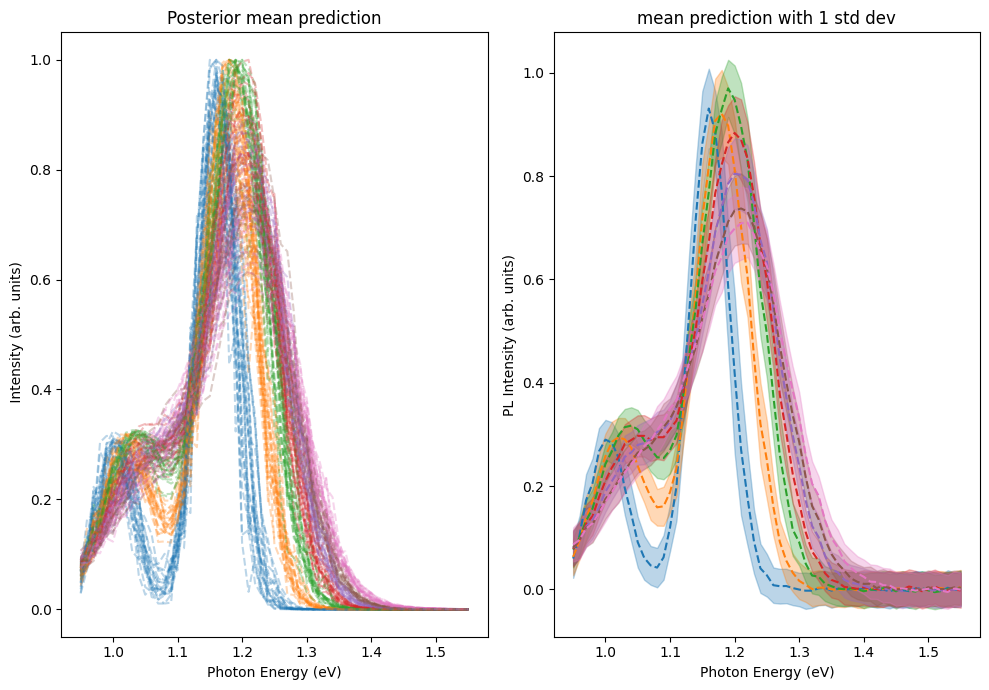

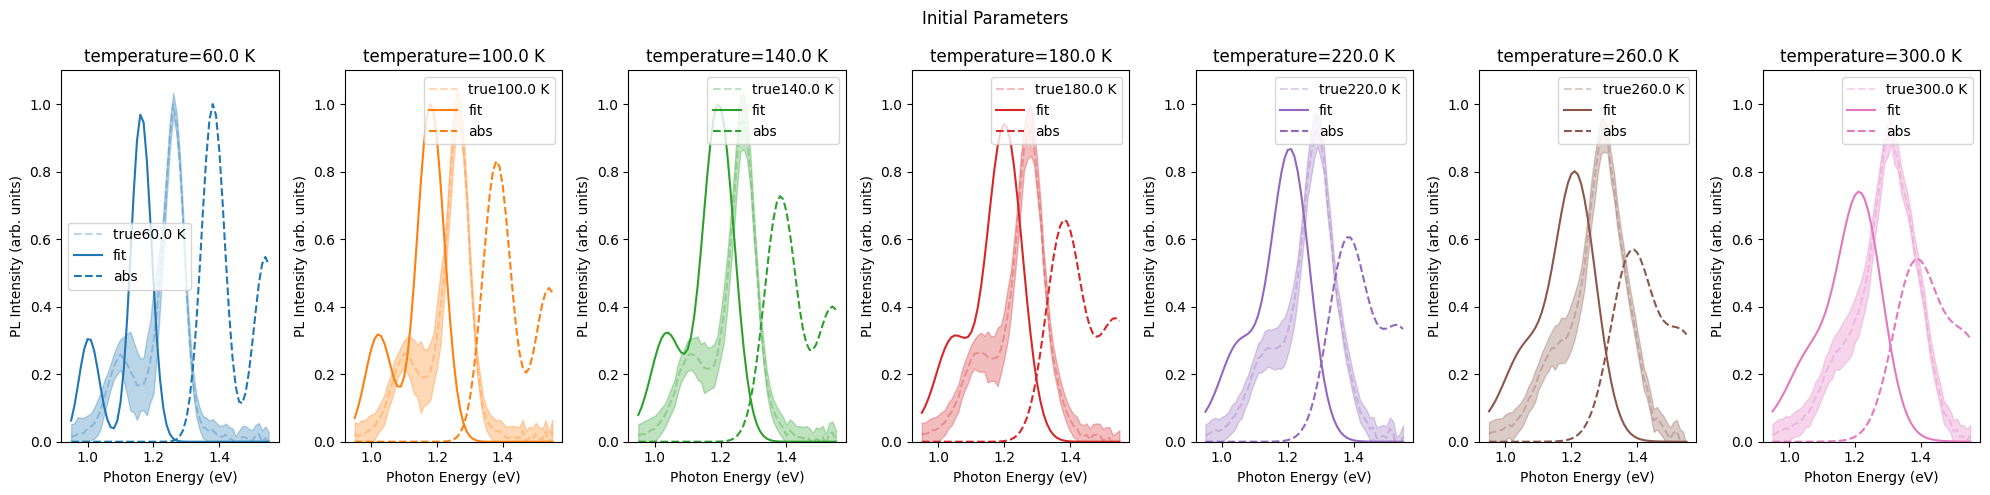

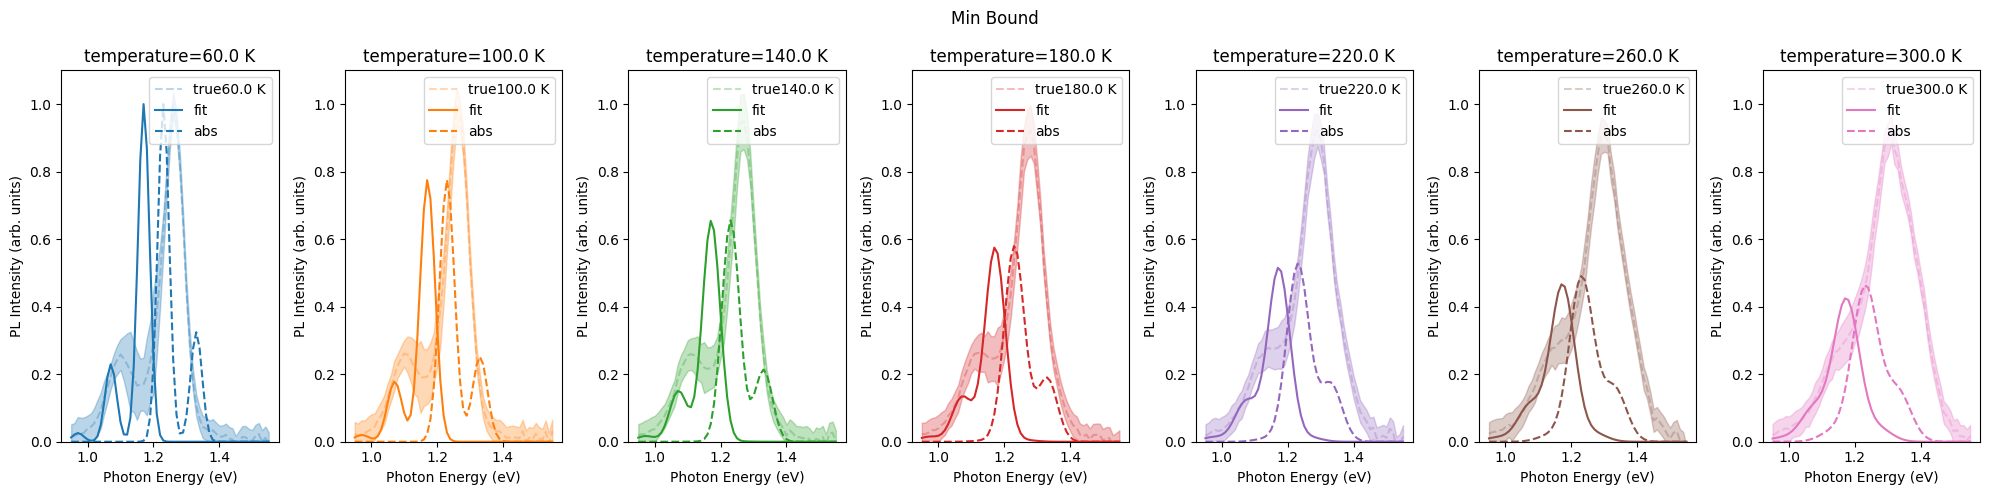

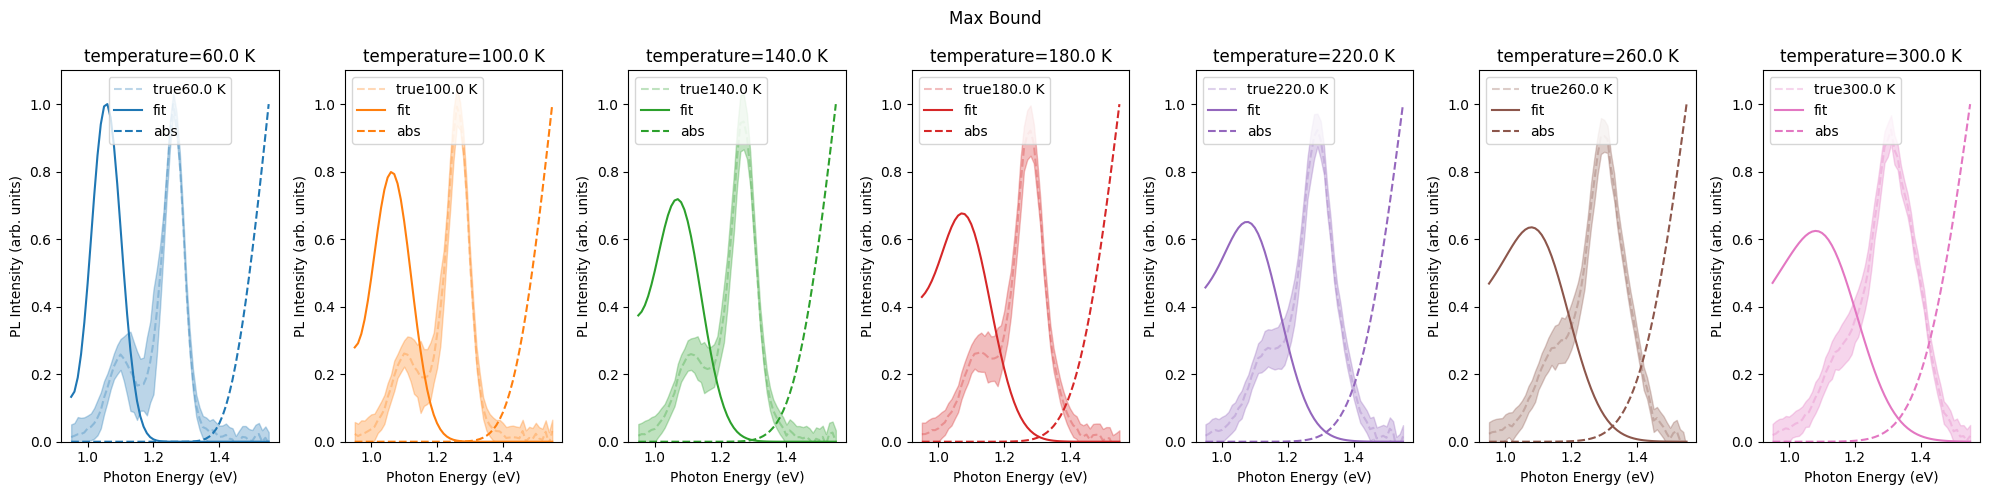

In [10]:
# plot the results with initial parameters
# and the maximum and minumum bounds
import importlib

from pl_temp_fit import fit_pl_utils

importlib.reload(fit_pl_utils)

fit_pl_utils.plot_fit_limits(model_config, model_config_save)

In [35]:
# modify the bounds
import importlib

importlib.reload(config_utils)

(
    number_free_parameters,
    Temp_std_err,
    hws_std_err,
    relative_intensity_std_error_pl,
    sigma,
) = (5, 10, 0.005, 0.05, 0.001)
params_to_fit_init = {
    "EX": {"E": 1.37, "sigma": 0.01, "Li": 7.8e-2, "Lo": 0.11, "hO": 0.159, "disorder_ext": 0.1},
    "CT": {},
    "D": {},
}
min_bounds = {
    "EX": {"E": 1.2, "sigma": 0.001, "Li": 0.03, "Lo": 0.03, "hO": 0.1, "disorder_ext": 0.1},
    "CT": {},
    "D": {},
}
max_bounds = {
    "EX": {"E": 1.6, "sigma": 0.1, "Li": 0.2, "Lo": 0.2, "hO": 0.2, "disorder_ext": 0.1},
    "CT": {},
    "D": {},
}
# save the model config
model_config, test_id = config_utils.save_model_config(
    csv_name_pl=csv_name,
    Temp_std_err=Temp_std_err,
    hws_std_err=hws_std_err,
    relative_intensity_std_error_pl=relative_intensity_std_error_pl,
    temperature_list_pl=temperature_list,
    hws_pl=hws,
    sigma=sigma,
    fixed_parameters_dict=fixed_parameters_dict,
    params_to_fit_init=params_to_fit_init,
    min_bounds=min_bounds,
    max_bounds=max_bounds,
    num_iteration_max_likelihood=5,
    coeff_spread=0.5,
    nsteps=10000,
    num_coords=32,
    database_folder="fit_experimental_emcee_pl/fit_data_base/",
    data_folder="fit_experimental_emcee_pl/fit_data/",
    test_id=test_id,
)

size of hw is (66,)
size of temperature_list is (5,)


In [27]:
csv_name

'/media/mohammed/Work/Work/pl_temp_fit/experiemental_data/2023-12-12-Lowtemp-PL/L8BO_mod_split200.0_split310.csv'